In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import pandas as pd
import numpy as np
import time
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import LabelBinarizer

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
df = pd.read_csv('KolkataDataset.csv',encoding='utf-8')
df.dropna(inplace=True)
df.head(5)

,Unnamed: 0,tweet,label
0,0,sudden breakdown vehicle maa flyover near bisw...,Vehicle breakdown
1,1,due dispersal sri sri academy traffic slow ali...,Roads related congestion
2,2,sudden breakdown vehicle ajc bose flyover near...,Vehicle breakdown
3,3,peak hours rush slowed traffic maa flyover tow...,Roads related congestion
4,4,sudden breakdown vehicle maa flyover slowed tr...,Vehicle breakdown


In [4]:
Y = df['label']
Y.value_counts()

City program                2150
Roads related congestion    1811
Vehicle breakdown           1636
Closed Avenue               1375
Others                      1101
Road blockage                254
Name: label, dtype: int64

[Text(0, 0, 'Vehicle breakdown'),
 Text(1, 0, 'Roads related congestion'),
 Text(2, 0, 'Others'),
 Text(3, 0, 'City program'),
 Text(4, 0, 'Closed Avenue'),
 Text(5, 0, 'Road blockage')]

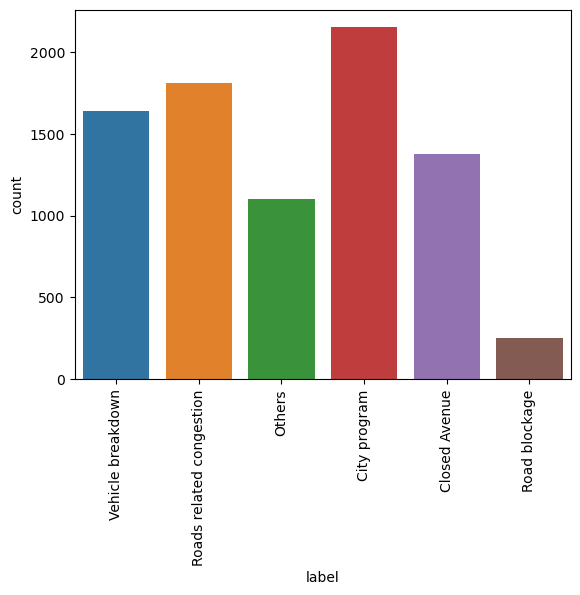

In [65]:
s = sns.countplot(x='label',data=df)
s.set_xticklabels(s.get_xticklabels(),rotation=90)

In [6]:
lb = LabelBinarizer()
y = lb.fit_transform(Y)
y

array([[0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 1],
       ...,
       [0, 0, 0, 0, 1, 0],
       [0, 1, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0]])

## Devide Data into Train Test

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(df['tweet'],y, stratify=df['label'])
X_train.shape, X_test.shape

((6245,), (2082,))

In [8]:
import pickle
with open('KolkataTrainTestData', 'wb') as file_pi:
    pickle.dump([X_train, X_test, Y_train, Y_test], file_pi)

In [9]:
bert_preprocess = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3')
bert_encoder = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4')

In [10]:
def get_sentence_embedding(sentences):
  preprocessed_text = bert_preprocess(sentences)
  return bert_encoder(preprocessed_text)['pooled_output']

get_sentence_embedding([
    'Hello My name is Pratik',
    'You have won a lottery! please click the link to accept it'
    ])

<tf.Tensor: shape=(2, 768), dtype=float32, numpy=
array([[-0.8533978 , -0.48276782, -0.704772  , ..., -0.6499928 ,
        -0.71603936,  0.8793282 ],
       [-0.7779393 , -0.31375867, -0.34136838, ..., -0.16125   ,
        -0.63032675,  0.8353147 ]], dtype=float32)>

# BERT Model Configuration

In [11]:
# Bert Layers
text_input_layer = tf.keras.Input(shape=(),dtype=tf.string,name='input')
preprocessed_text_layer = bert_preprocess(text_input_layer)
encoder_layer = bert_encoder(preprocessed_text_layer)

# Neural network layers
n1 = tf.keras.layers.Dropout(0.1,name = 'DropOut')(encoder_layer['pooled_output'])
# n2 = tf.keras.layers.Dense(128, activation='ReLU', name="Dense1")(n1)
output = tf.keras.layers.Dense(len(lb.classes_), activation='softmax', name="Output")(n1)

# Use inputs and outputs to construct a final model
model = tf.keras.Model(inputs=[text_input_layer], outputs = [output])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_type_ids':   0           ['input[0][0]']                  
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128),                                                          
                                 'input_word_ids':                                                
                                (None, 128)}                                                  

In [12]:
METRICS = [
    tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall')
]

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

### Training

In [13]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import tensorflow as tf
st = time.time()
epochs = 50
batch_size = 512

checkpoint_path = 'BertKolkata_1/cp-{epoch:03d}.ckpt'
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1, 
    save_weights_only=True,
    save_freq=2*batch_size)


# model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
#     filepath=checkpoint_filepath,
#     save_weights_only=True,
#     verbose=1,
#     monitor='val_accuracy',
#     mode='max',
#     save_best_only=True)

# history = model.fit(X_train, y_train, epochs = epochs, batch_size=32)
history = model.fit(X_train, Y_train, epochs = epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001),cp_callback])

et = time.time()
elapsed_time = et - st
print('Execution time: {:0.0f} seconds'.format(elapsed_time))

model.save('Bert_Kolkata_model.h5')

import pickle
with open('Bert_Kolkata_history', 'wb') as file_pi:
    pickle.dump(history, file_pi)

Epoch 1/50
11/11 [==============================] - 712s 64s/step - loss: 1.7063 - accuracy: 0.2673 - val_loss: 1.6622 - val_accuracy: 0.3664
Epoch 2/50
11/11 [==============================] - 705s 65s/step - loss: 1.6373 - accuracy: 0.2950 - val_loss: 1.5919 - val_accuracy: 0.3680
Epoch 3/50
11/11 [==============================] - 692s 64s/step - loss: 1.5894 - accuracy: 0.3402 - val_loss: 1.5594 - val_accuracy: 0.4080
Epoch 4/50
11/11 [==============================] - 705s 65s/step - loss: 1.5555 - accuracy: 0.3692 - val_loss: 1.5294 - val_accuracy: 0.4624
Epoch 5/50
11/11 [==============================] - 692s 64s/step - loss: 1.5205 - accuracy: 0.4028 - val_loss: 1.5007 - val_accuracy: 0.4736
Epoch 6/50
11/11 [==============================] - 702s 65s/step - loss: 1.4922 - accuracy: 0.4217 - val_loss: 1.4756 - val_accuracy: 0.4928
Epoch 7/50
11/11 [==============================] - 689s 63s/step - loss: 1.4591 - accuracy: 0.4443 - val_loss: 1.4400 - val_accuracy: 0.5152
Epoch 

# Load Model, History and Dataset

In [14]:
import keras

model = tf.keras.models.load_model('Bert_Kolkata_model.h5',custom_objects={'KerasLayer':hub.KerasLayer})
# new_model = tf.keras.models.load_model('saved_model/my_model')

In [15]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_type_ids':   0           ['input[0][0]']                  
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128),                                                          
                                 'input_word_ids':                                                
                                (None, 128)}                                                  

In [16]:
import pickle
with open('Bert_Kolkata_history', "rb") as file_pi:
    history = pickle.load(file_pi)

ValueError: Unknown layer: 'KerasLayer'. Please ensure you are using a `keras.utils.custom_object_scope` and that this object is included in the scope. See https://www.tensorflow.org/guide/keras/save_and_serialize#registering_the_custom_object for details.

In [ ]:
with open('KolkataTrainTestData', 'rb') as file_pi:
    temp = pickle.load(file_pi)
X_train = temp[0] 
X_test = temp[1]
y_train = temp[2]
y_test = temp[3]

## Perform on Test Data

In [56]:
accr = model.evaluate(X_test,Y_test)
print("Accuracy of model on test data : " , accr[1]*100 , "%")

66/66 [==============================] - 203s 3s/step - loss: 0.9295 - accuracy: 0.7205
Accuracy of model on test data :  72.04610705375671 %


In [57]:
pred_test = model.predict(X_test)

66/66 [==============================] - 195s 3s/step


In [58]:
y_pred = lb.inverse_transform(pred_test)
y_test = lb.inverse_transform(Y_test)

## Result Analysis 

### Plot Training Testing Accuracy-Loss

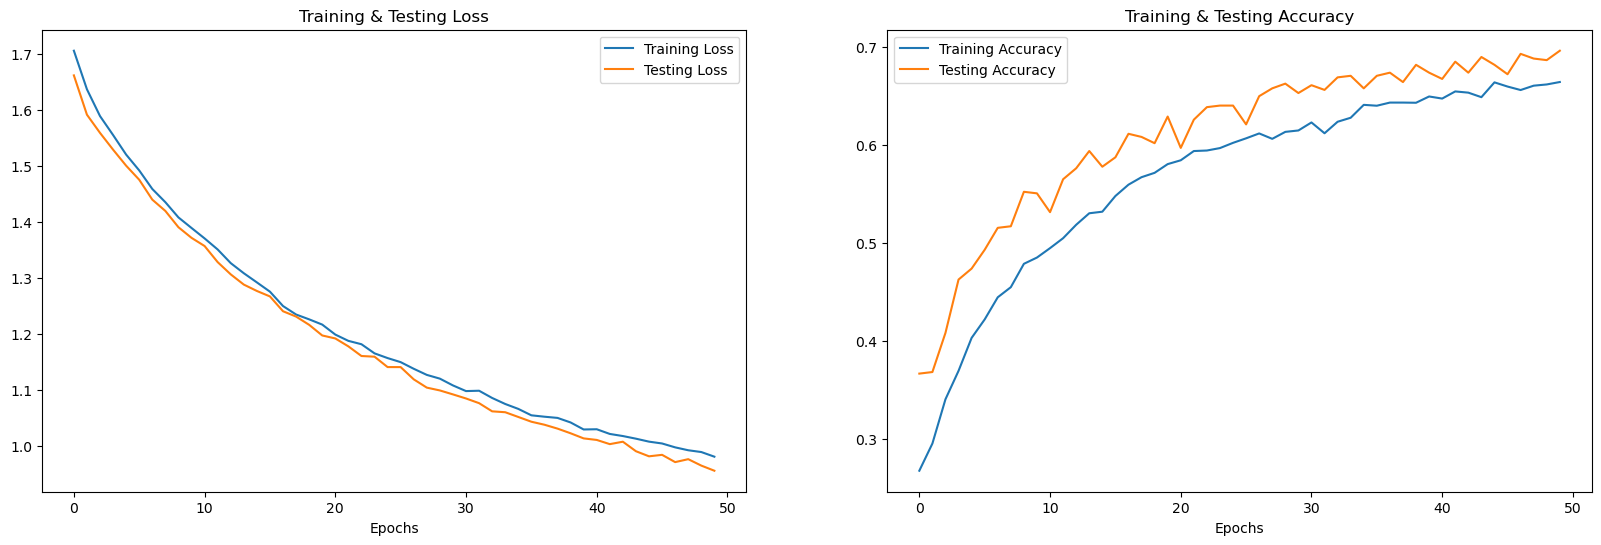

In [59]:
import matplotlib.pyplot as plt

epochList = [i for i in range(len(history.history['loss']))]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochList , train_loss , label = 'Training Loss')
ax[0].plot(epochList , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochList , train_acc , label = 'Training Accuracy')
ax[1].plot(epochList , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

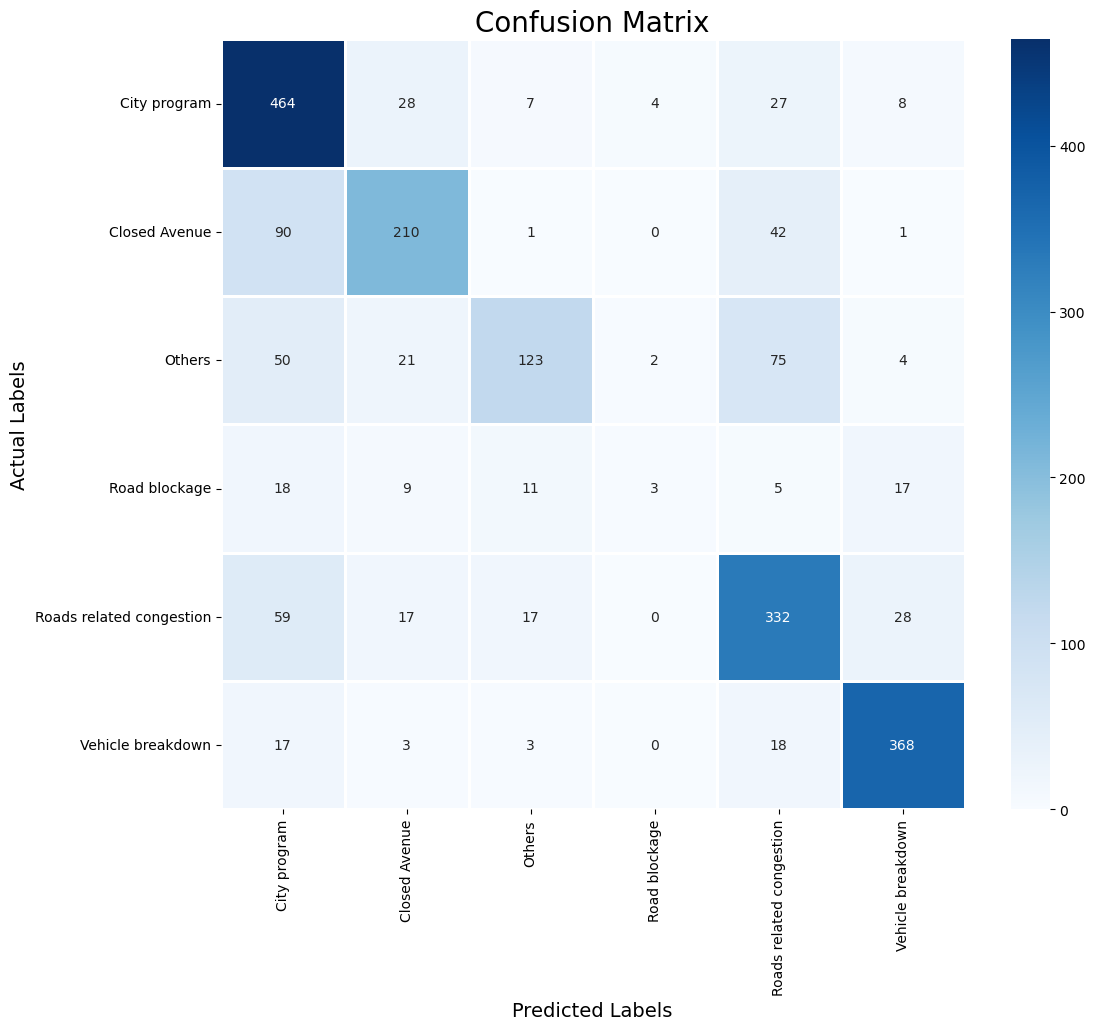

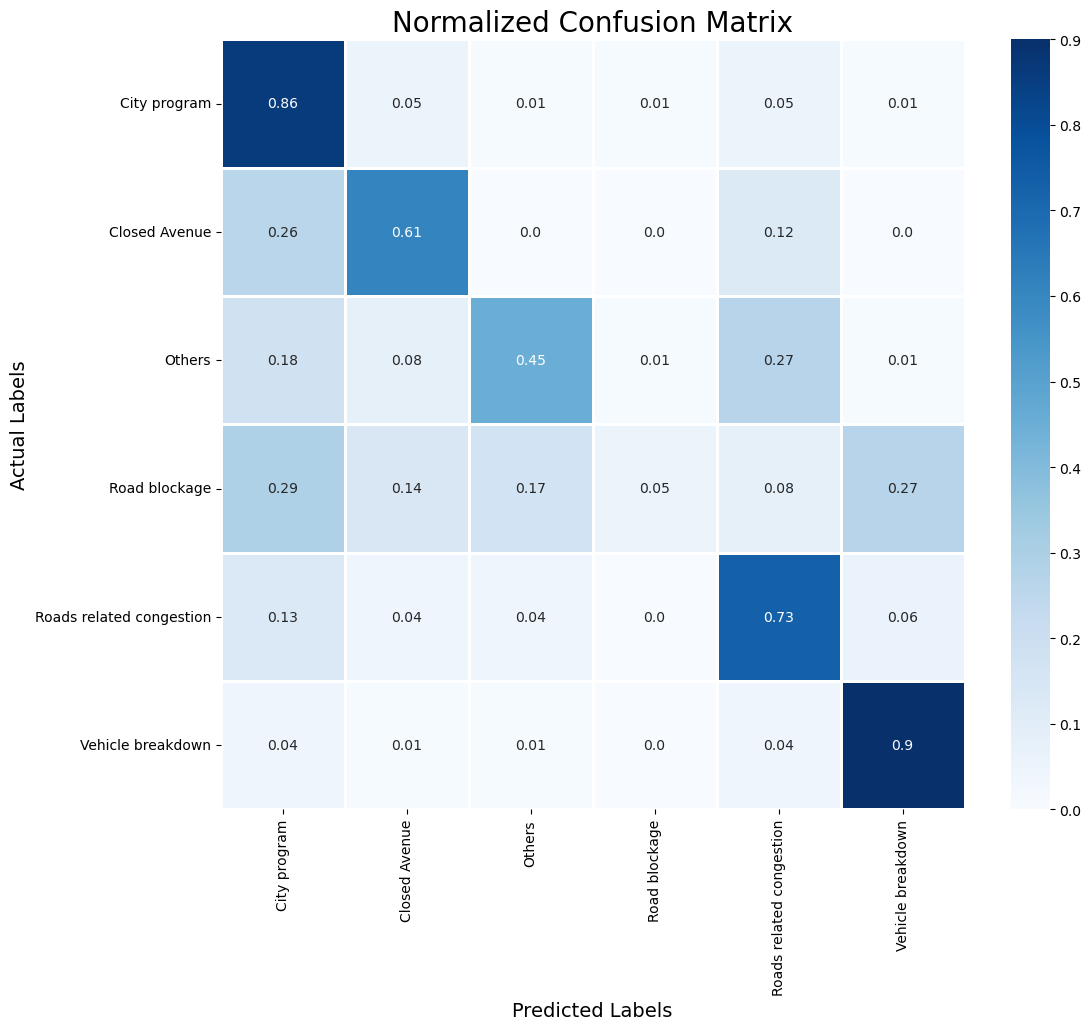

In [60]:
cm = confusion_matrix(y_test, y_pred)
# cm= np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in lb.classes_] , columns = [i for i in lb.classes_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

cm = confusion_matrix(y_test, y_pred)
cm= np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in lb.classes_] , columns = [i for i in lb.classes_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Normalized Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [61]:
print(classification_report(y_test, y_pred))

                          precision    recall  f1-score   support

            City program       0.66      0.86      0.75       538
           Closed Avenue       0.73      0.61      0.66       344
                  Others       0.76      0.45      0.56       275
           Road blockage       0.33      0.05      0.08        63
Roads related congestion       0.67      0.73      0.70       453
       Vehicle breakdown       0.86      0.90      0.88       409

                accuracy                           0.72      2082
               macro avg       0.67      0.60      0.61      2082
            weighted avg       0.72      0.72      0.71      2082



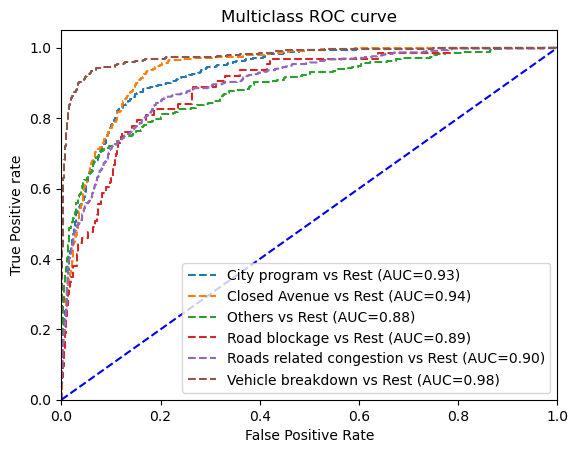

In [62]:
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve,auc

# roc curve for classes
fpr = {}
tpr = {}
thresh ={}
roc_auc = dict()

classes = lb.classes_

for i in range(len(classes)):
    # fpr[i], tpr[i], thresh[i] = roc_curve(y_test_binarized[:,i], pred_prob[:,i])
    fpr[i], tpr[i], thresh[i] = roc_curve(Y_test[:,i], pred_test[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])

    # plotting
    plt.plot(fpr[i], tpr[i], linestyle='--',
             label='%s vs Rest (AUC=%0.2f)'%(classes[i],roc_auc[i]))

plt.plot([0,1],[0,1],'b--')
plt.xlim([0,1])
plt.ylim([0,1.05])
plt.title('Multiclass ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='lower right')
plt.show()

In [63]:
from sklearn.metrics import roc_auc_score
roc_auc = roc_auc_score(y_test, pred_test,multi_class='ovr')
print("ROC-AUC Score:", roc_auc)

ROC-AUC Score: 0.9176339571202504


In [64]:
from sklearn.metrics import precision_recall_fscore_support as score
precision, recall, fscore,_  = score(y_test, y_pred, average='macro')
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy, precision, recall, fscore, Roc-AUC')
print('{:.3f},{:.3f},{:.3f},{:.3f},{:.3f}'.format(accuracy,precision,recall,fscore,roc_auc))

Accuracy, precision, recall, fscore, Roc-AUC
0.720,0.669,0.600,0.607,0.918
